In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../data/bikes_by_hour.csv', index_col='instant')

In [3]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

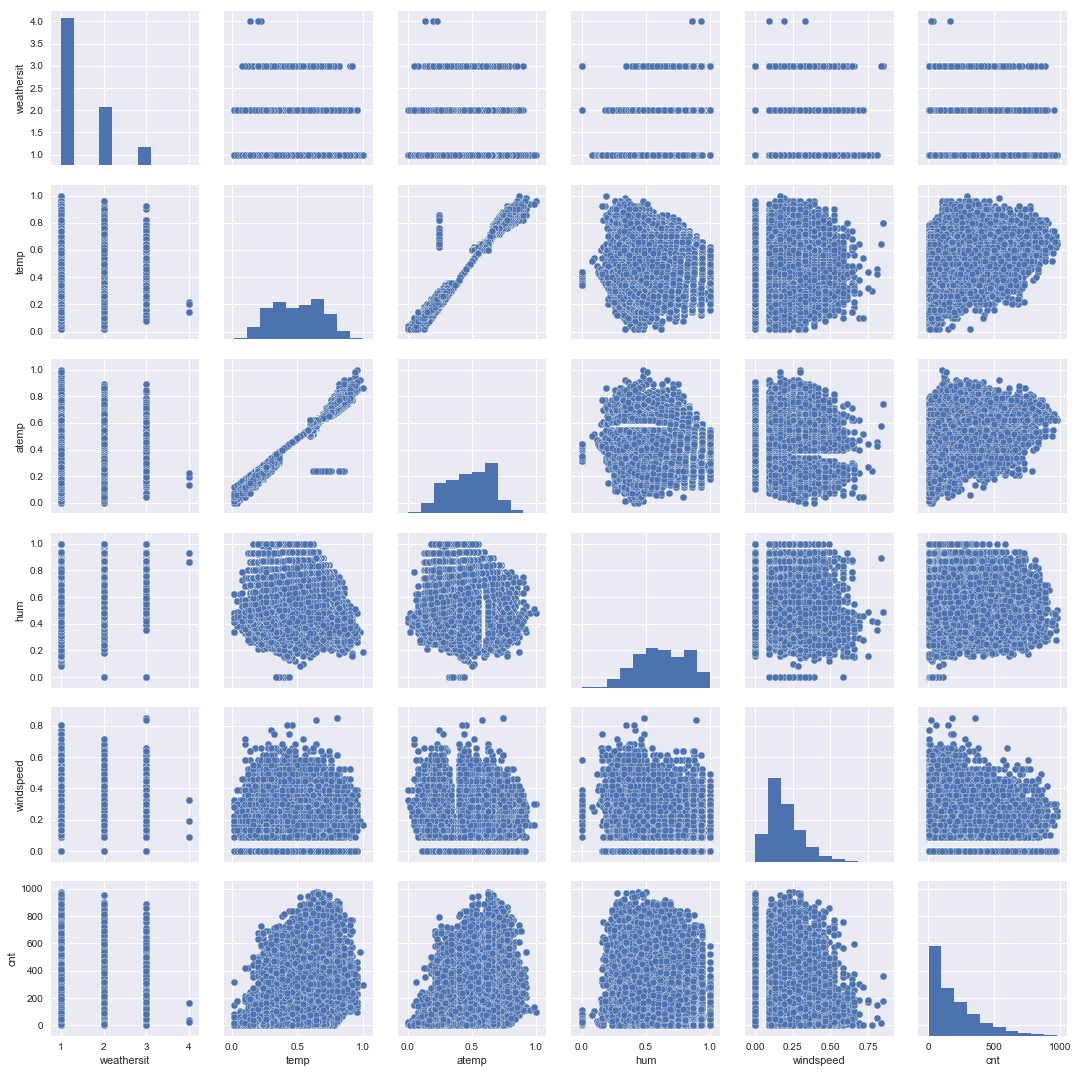

In [5]:
sns.pairplot(df[['weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']])

Целевой признак стоит логарифмировать (и прогнозировать уже логарифм)

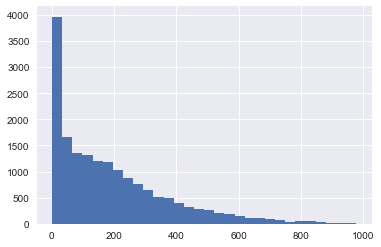

In [6]:
df['cnt'].hist(bins=30);

In [7]:
import numpy as np

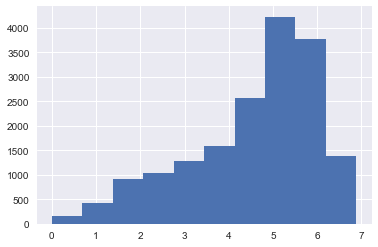

In [8]:
df['cnt'].apply(np.log).hist();

1 прибавляем, т.к. логарифм плохо ведет себя в районе 0

In [9]:
X, y = df.drop(['casual', 'registered', 'cnt', 'dteday'], axis = 1), df['cnt']

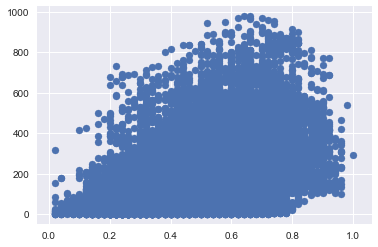

In [10]:
plt.scatter(X['temp'], y);

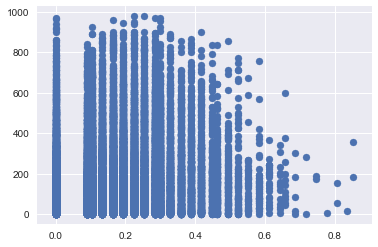

In [11]:
plt.scatter(X['windspeed'], y);

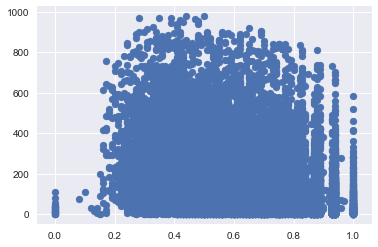

In [12]:
plt.scatter(X['hum'], y);

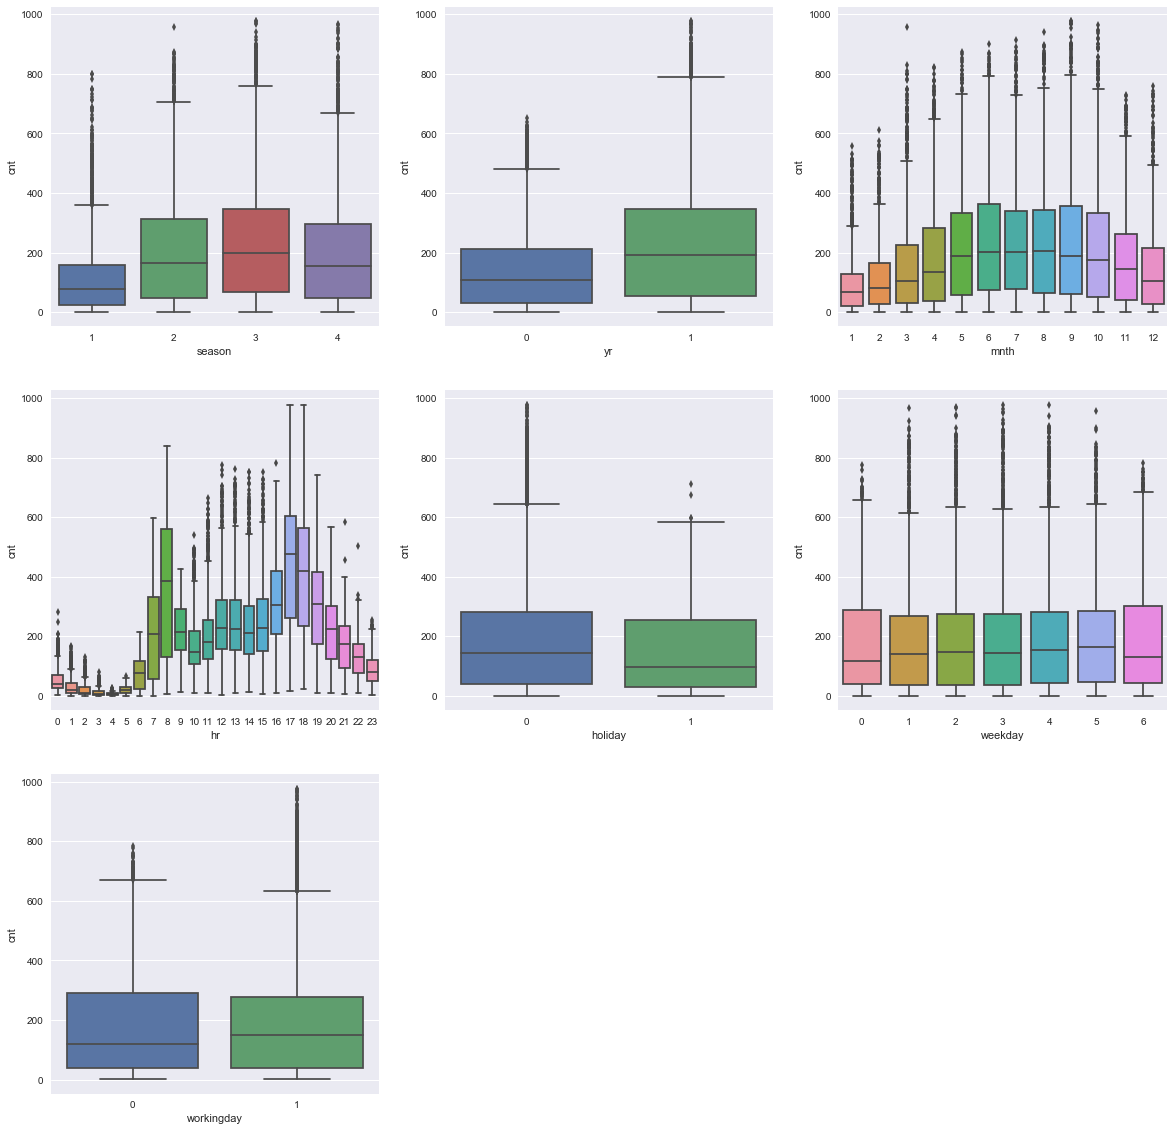

In [13]:
plt.rcParams['figure.figsize'] = (20,20)
for i, feat in enumerate(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday']):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=X[feat], y=y);

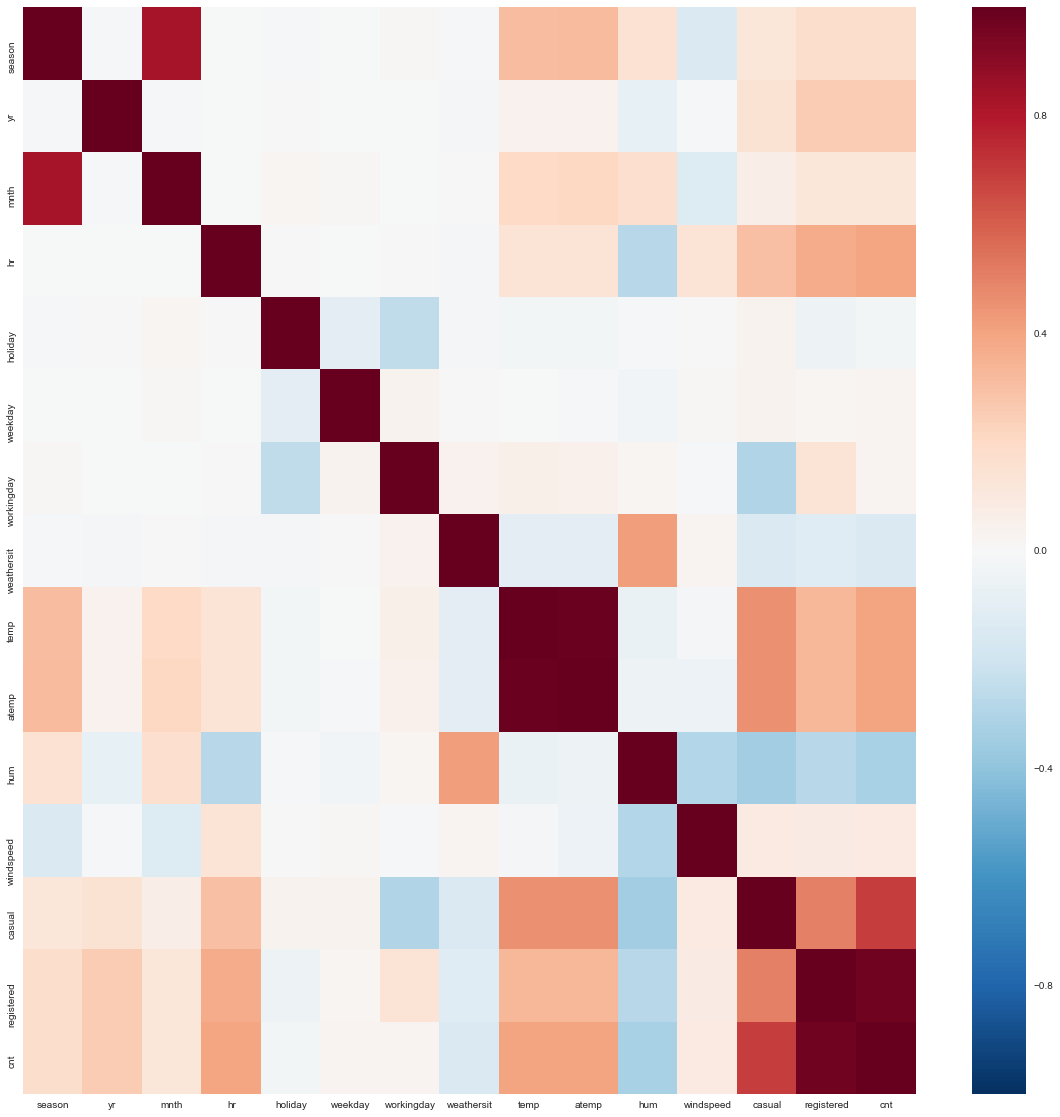

In [14]:
sns.heatmap(df.corr());

In [15]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

In [16]:
ols_model = LinearRegression()

In [17]:
pd.to_datetime(df['dteday']).head()

instant
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
5   2011-01-01
Name: dteday, dtype: datetime64[ns]

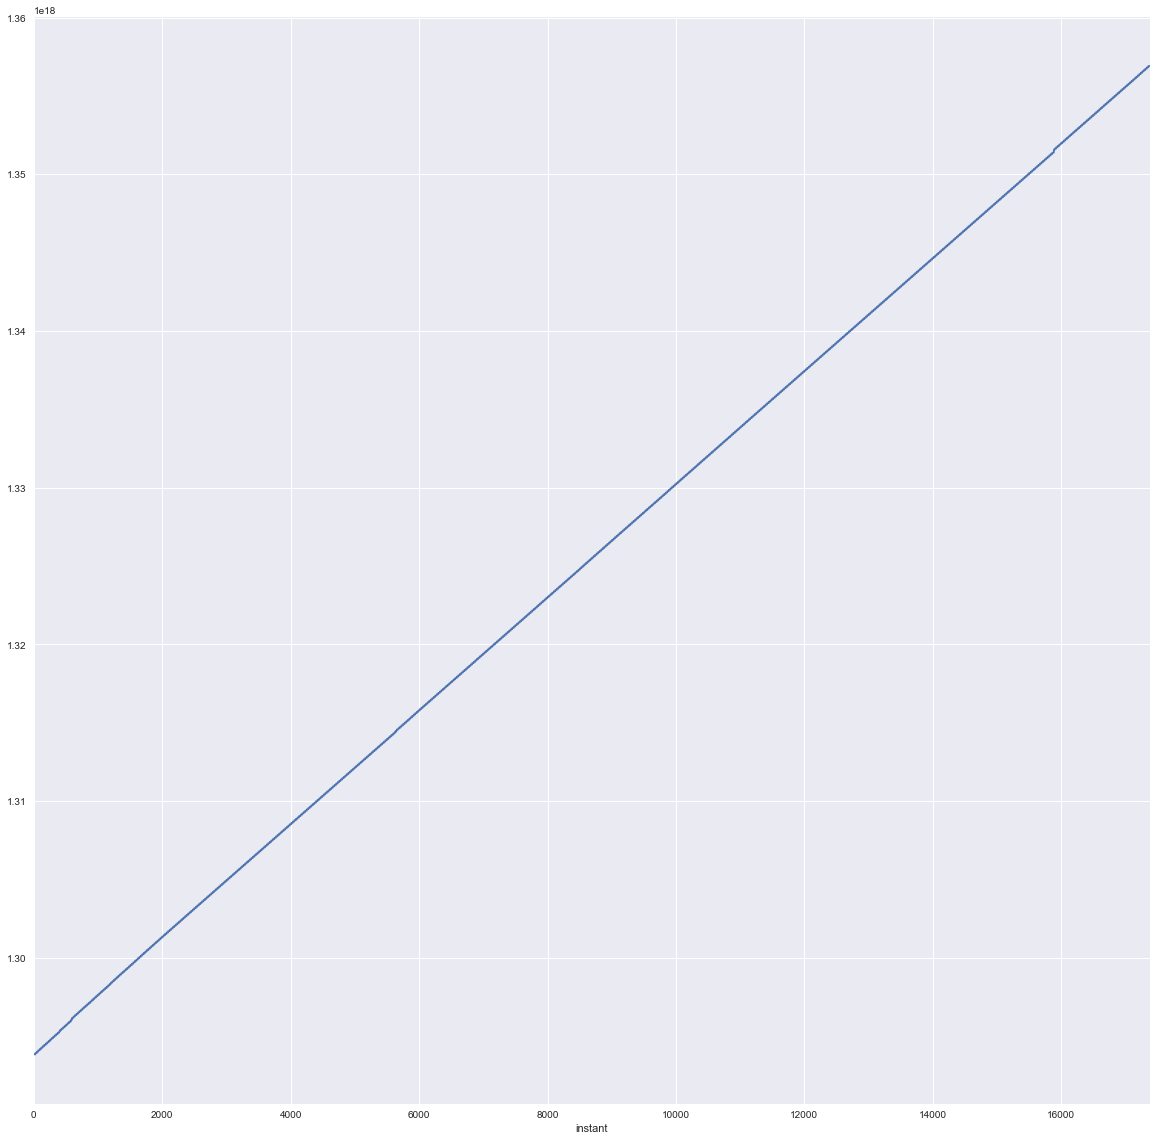

In [18]:
df['dteday'].apply(lambda ts: pd.to_datetime(ts).value).plot();

Итак, данные отсортированы по времени. 

In [19]:
train_size = int(0.7 * df.shape[0])

In [20]:
X_train, X_valid = X.values[:train_size, :], X.values[train_size:, :]

In [21]:
y_valid.shape

NameError: name 'y_valid' is not defined

In [24]:
y_train, y_valid = y.values[:train_size], y.values[train_size:]

In [25]:
ols_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
ols_valid_pred = ols_model.predict(X_valid)

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
np.sqrt(mean_squared_error(y_valid, ols_valid_pred))

184.58512708591147

In [29]:
y.min(), y.max()

(1, 977)

In [30]:
ols_model.coef_

array([  12.83530169,   86.58881085,    1.64494833,    6.55819547,
        -22.16157875,    1.57353568,   -0.63809235,   -6.70111343,
         50.75172707,  258.38149703, -151.47165911,   20.63723044])

In [31]:
pd.DataFrame({'feat': X.columns, 'coef': ols_model.coef_})

,coef,feat
0,12.835302,season
1,86.588811,yr
2,1.644948,mnth
3,6.558195,hr
4,-22.161579,holiday
5,1.573536,weekday
6,-0.638092,workingday
7,-6.701113,weathersit
8,50.751727,temp
9,258.381497,atemp


Большие коэффициенты

In [32]:
lasso_model = Lasso()

In [33]:
lasso_model.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
lasso_valid_pred = lasso_model.predict(X_valid)

In [35]:
np.sqrt(mean_squared_error(y_valid, lasso_valid_pred))

185.94166952706692

In [36]:
pd.DataFrame({'feat': X.columns, 'coef': lasso_model.coef_}).sort_values('coef', ascending = False)

,coef,feat
8,251.283699,temp
1,81.377272,yr
0,11.655459,season
3,6.898368,hr
2,1.754923,mnth
5,1.564279,weekday
4,-0.000000,holiday
6,0.000000,workingday
9,0.000000,atemp
11,0.000000,windspeed


In [37]:
lasso_grid = LassoCV(n_alphas=3000).fit(X_train, y_train)

In [38]:
lasso_tuned_valid_pred = lasso_grid.predict(X_valid)

In [39]:
np.sqrt(mean_squared_error(y_valid, lasso_tuned_valid_pred))

187.99778300650135

In [40]:
lasso_grid.alphas_

array([  4.18723204e+02,   4.17759846e+02,   4.16798705e+02, ...,
         4.20656588e-01,   4.19688782e-01,   4.18723204e-01])

In [41]:
ridge_grid = RidgeCV(alphas=np.logspace(-2,2,3000)).fit(X_train, y_train)

In [42]:
ridge_tuned_valid_pred = ridge_grid.predict(X_valid)

In [43]:
np.sqrt(mean_squared_error(y_valid, ridge_tuned_valid_pred))

184.58951151563741

In [44]:
ols_model2 = LinearRegression().fit(X_train, np.log1p(y_train))

In [46]:
np.sqrt(mean_squared_error(y_valid, 
                           np.exp(ols_model2.predict(X_valid) - 1)))

254.70417845214661

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
forest = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=17)

In [49]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=17,
           verbose=0, warm_start=False)

In [50]:
forest_valid_pred = forest.predict(X_valid)

In [51]:
np.sqrt(mean_squared_error(y_valid, forest_valid_pred))

74.835743684550479